# 2022 Earth Lab Capstone Project 
# Where can soil moisture improve rainfall-triggered landslide predictability?
## Student: Jacquelyn Witte
## Mentor: Elsa Culler (CU/CIRES)

In [1]:
import os
os.system('jupyter nbconvert --to html --no-input Jacquie-Witte_CapstoneBlogpost_May2022.ipynb')

import earthpy as et
import folium
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from geopandas import GeoDataFrame
from shapely.geometry import Point

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

[NbConvertApp] Converting notebook Jacquie-Witte_CapstoneBlogpost_May2022.ipynb to html
[NbConvertApp] Writing 643247 bytes to Jacquie-Witte_CapstoneBlogpost_May2022.html


## Why do we care about landslides?


Landslides have significant economic impacts. There can be loss of life, wildlife and wildlife habitat. Landslides are a serious geologic hazard common to many areas in the US and Canada. In Colorado, which is where I live, a high percentage of our population lives in the Rockies. So transportation and infrastructure are impacted as you can see from the CNN caption below of a mudslide event on the I-70 which is our main highway artery across the Rockies.

<div>
<img src="images/cnn_newsarticle_glenspringsLandslideCO.png " width="500"/>
</div>



On another note, my husband I were driving home from the Oregon coast during an Atmospheric river event and there were crews along the valley roads building retaining walls to prevent landslides because of the soil erosion caused by wildfires in that region. So climate change is also factor and one which confounds our ability to predict rainfall trigger landslides. Climate change is a chaotic system and the basis of all models is pattern and order. 

This is where soil moisture and composition and knowing the history of the area and land-uses come into play in this project. 

## Motivation and Approach

Landslides have multiple causes:  rainfall, snowmelt, erosion, earthquakes, volcanoes, disturbance by human activities, or any combination of these and other factors. This study focuses on rainfall-triggered landslides. Predicting them with a high degree of accuracy to save lives and maintain infrastructure is challenging. Precipitation data sources are heterogeneous - radar, satellite, in-situ and ensemble model predictions using available precipitation products carry large uncertainties (https://onlinelibrary.wiley.com/doi/full/10.1002/hyp.14260). This make it challenging to predict the timing, severity, extent, and even likelihood that a landslide will occur. 

Soil moisture can be a potential indicator of the type of rainfall induced landslide. We can use soil moisture data to group landslides into two types (1) shallow slope failures - saturation induced by rainfall infiltration and (2) run off driven landslides - triggered by intense storms.  This informs the forecaster which models and precipitation products are optimal to use to better predict a landslide event.

The purpose of this study is to address the need to improve our understanding of landslides caused by rainfall by 
- Examining the relationship between soil moisture and precipitation during landslide events. 
- Using soil moisture as an accuracy indicator for triggering landslide events.
- Quantify landslide predictability using soil moisture, i.e. does adding soil moisture information improve the predictions?


This work follows ongoing research done by Elsa Culler and colleagues in their paper:
> Culler, E. S., Badger, A. M., Minear, J. T., Tiampo, K. F., Zeigler, S. D., & Livneh, B. (2021). A multi-sensor evaluation of precipitation uncertainty for landslide-triggering storm events. Hydrological Processes, 35( 7), e14260. https://doi.org/10.1002/hyp.14260

## Study region: Colorado, USA

The study area will be Colorado, because I live here and am somewhat familiar with the landscape. 

Towns and cities in Colorado's mountainous or hilly terrain are growing and spreading as populations move into these popular destination areas. It is important to understand the potential exposure to landslide hazards, and how counties can maintain optimal land-use and infrastructure to reduce the costs of living with landslides. 

## Timeperiod

#### We choose a starting time period of 2015 to coincides with when SMAP started collecting data.

A lot of people live in the Rockies. It is a popular tourist destination year-round, people continue to move to the Rockies - This is a popular area, to say the least!


#### Below is map of the Colorado with all the Landslide events between 2007-2016. The locations are color coated by trigger - Continuous rain, downpour, rain, tropical cyclone which we have one documented and unknown.</h4>

> Data Source: Global Landslide Catalog https://doi.org/10.1002/hyp.14260

In [2]:
# Change to data directory
data_dir = os.path.join(et.io.HOME,
                        'earth-analytics',
                        'data')
os.chdir(data_dir)

# Read Global Landslide Catalog CSV to a dataFrame
glc = pd.read_csv(os.path.join('capstone', 
                               'landslide', 
                               'nasa_global_landslide_catalog_point.csv'))
# Subset to Colorado and remove non-rainfall events
glc_co = glc[(glc['country_code'] == 'US') & (
                glc['admin_division_name'] == 'Colorado') & (
                glc['landslide_trigger'] != 'freeze_thaw') & (
                glc['landslide_trigger'] != 'snowfall_snowmelt') & (
                glc['landslide_trigger'] != 'no_apparent_trigger') & (
                glc['landslide_trigger'] != 'other')              & (
                glc['landslide_trigger'] != 'unknown')
            ]

# Convert to datetime
glc_co['date'] = pd.to_datetime(glc_co['event_date'])
glc_co = glc_co.set_index('date').sort_index()

# Isolate only beyond 2015
glc_co_gt2015 = glc_co[glc_co.index > '2015-04-01']

# Georeference the locations to plot on Folium
geometry = [Point(xy) for xy in zip(glc_co_gt2015['longitude'], 
                                    glc_co_gt2015['latitude'])]
crs = 'epsg:4326'
glc_co_epsg4326 = GeoDataFrame(glc_co_gt2015, crs=crs, geometry=geometry)

# Create a symbology dictionary that maps "type" to color. 
triggers = np.unique(glc_co_epsg4326['landslide_trigger'])
colors = ['red', 'green', 'blue', 'orange','lightgray']
points_symb = dict(zip(triggers,colors))

# ------- Map the Landslide events -----------------------------
# Create Title
loc = 'Rainfall-triggered Landslides in Colorado (2015 - 2020)'
title_html = '''
             <h3 align="center" style="font-size:16px"><b>{}</b></h3>
             '''.format(loc)   

m2 = folium.Map([39.0, -105.27], zoom_start=7, tiles='Stamen Terrain')

for i, loc in glc_co_epsg4326.iterrows():
    folium.Marker(location=[loc['latitude'], loc['longitude']],
                  icon=folium.Icon(color=points_symb[loc['landslide_trigger']],
                                   prefix='glyphicon', icon='off')).add_to(m2)
    
Dict = {'cr': {'raintype': 'Continuous Rain',
            'loc': [40.5, -103],
            'color': 'red',
            'textloc': [40.5, -102.7]},
        'dp': {'raintype': 'Downpour',
            'loc': [40, -103],
            'color': 'green',
            'textloc': [40, -102.7]},
        'rain': {'raintype': 'Rain',
            'loc': [39.5, -103],
            'color': 'blue',
            'textloc': [39.5, -102.7]},
        'tc': {'raintype': 'Tropical Cyclone',
            'loc': [39., -103],
            'color': 'orange',
            'textloc': [39., -102.7]}
        }
    
for key in Dict.keys():
    folium.CircleMarker(location=Dict[key]['loc'], radius=10,
                        color=Dict[key]['color'],
                        fill_color=Dict[key]['color'],
                        fill_opacity=1.0).add_to(m2)
    folium.Marker(
        location=Dict[key]['textloc'],
        icon=folium.DivIcon(
            html=f"""<b>{Dict[key]['raintype']}</b>""")
    ).add_to(m2)

#Add Title
m2.get_root().html.add_child(folium.Element(title_html))
m2

## What types of landslides and precipitation are occurring during these events?

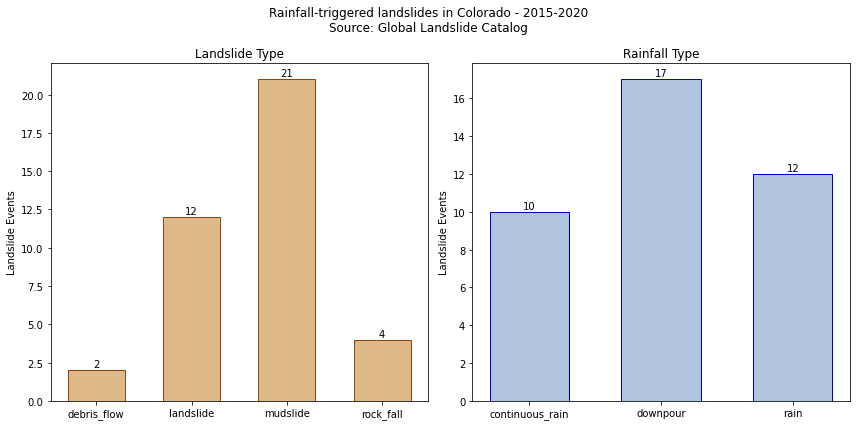

In [3]:
stack_size = []
labels_size = []
for i, data in glc_co_gt2015.groupby('landslide_category'):
    labels_size.append(i)
    stack_size.append(data['landslide_category'].count())

stack_trig = []
labels_trig = []
for i, data in glc_co_gt2015.groupby('landslide_trigger'):
    labels_trig.append(i)
    stack_trig.append(data['landslide_trigger'].count())

f, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))
width = 0.6

t1 = 'Rainfall-triggered landslides in Colorado - 2015-2020\n'
t2 = 'Source: Global Landslide Catalog'
f.suptitle(t1+t2, fontsize='large')

bars = ax1.bar(labels_size, stack_size, width,
               color='burlywood', edgecolor='saddlebrown')
ax1.set(ylabel='Landslide Events',
        title='Landslide Type')
ax1.bar_label(bars, padding=1)


bars = ax2.bar(labels_trig, stack_trig, width,
               color='lightsteelblue', edgecolor='mediumblue')
ax2.set(ylabel='Landslide Events',
        title='Rainfall Type')
ax2.bar_label(bars, padding=1)

f.tight_layout()

## Data Sources in this Blog

#### [NASA Global Landslide Catalog (2015-2020)](https://data.nasa.gov/Earth-Science/Global-Landslide-Catalog/h9d8-neg4)
> Kirschbaum, D. B., Adler, R., Hong, Y., Hill, S., & Lerner-Lam, A. (2010). A global landslide catalog for hazard applications: Method, results, and limitations. Natural Hazards, 52(3), 561–575. https://doi.org/10.1007/s11069-009-9401-4

The Global Landslide Catalog (GLC) was developed with the goal of identifying rainfall-triggered landslide events around the world, regardless of size, impacts or location. The GLC considers all types of mass movements triggered by rainfall, which have been reported in the media, disaster databases, scientific reports, or other sources. The GLC has been compiled since 2007 at NASA Goddard Space Flight Center.